In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
import pickle

import torchvision.models as models
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm.notebook import tqdm

In [2]:
images, labels = pickle.load(open('images_10_3.p', 'rb'))

In [3]:
images.shape

(11177, 100, 100, 3)

In [4]:
images[:, 0].mean(), images[:, 0].std()

(89.34033193164534, 49.83985561144281)

In [5]:
images.max(), images.min()

(255, 0)

In [6]:
# Split the classes in a balanced way

# Calculate the class frequencies
class_counts = Counter(labels)

# Calculate the number of samples in the train and test sets
num_samples = len(labels)
split_ratio = 0.8  # 80/20 train/test split
num_train_samples = int(num_samples * split_ratio)
num_test_samples = num_samples - num_train_samples

# Create a list of tuples, where each tuple contains the class label and the corresponding indices of the samples
label_indices = [(label, np.where(labels == label)[0]) for label in class_counts.keys()]

# Initialize the train and test sets
train_indices = []
test_indices = []

# Loop over the list of tuples
for label, indices in label_indices:
    # Calculate the number of samples for this class
    num_samples = len(indices)

    # Calculate the number of samples in the train and test sets for this class
    num_train_samples = int(num_samples * split_ratio)
    num_test_samples = num_samples - num_train_samples

    # Select the train and test indices for this class
    train_indices += random.sample(list(indices), num_train_samples)
    test_indices += [i for i in indices if i not in train_indices]

In [7]:
# check if they are balanced?

np.unique(labels[train_indices], return_counts=True), np.unique(labels[test_indices], return_counts=True)

((array([0, 1, 2, 3, 4]), array([7732,  354,  328,  222,  304])),
 (array([0, 1, 2, 3, 4]), array([1934,   89,   82,   56,   76])))

In [8]:
num_classes = len(np.unique(labels, return_counts=False))

In [9]:
# load a pretrained resnet152 from torchvision

model = models.__dict__["resnet152"](pretrained=True)
model.fc = nn.Linear(model.fc.weight.shape[1], num_classes)

In [10]:
# dataset class to create a data loader

class DDSM(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # images are in [0, 255] scale, normalize to [0, 1]
        image, label = self.images[idx]/255, self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image.float(), label

In [11]:
# function to test the model

def validation(model, val_dataloader, device="cpu"):
    
    total_loss = 0.0  # Initialize the loss sum to 0
    total_acc = 0.0   # Initialize the accuracy sum to 0
    num_samples = 0   # Initialize the number of samples processed to 0
    
    # Disable gradient calculation
    with torch.no_grad():
        
        # Loop over the validation data
        for inputs, labels in tqdm(val_dataloader):
            
            # Move the inputs and labels to the specified device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass through the model
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Calculate the accuracy
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).float().sum()
            
            total_loss += loss.item()
            total_acc += accuracy.item()
            num_samples += inputs.size(0)
    
    val_accuracy = total_acc / num_samples
    val_loss = total_loss / len(val_dataloader)
    
    return val_loss, val_accuracy

In [12]:
# training the model

def train(model, criterion, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs=10, device='cpu'):
    
    # Move model to the specified device
    model.to(device)

    # Set the model to training mode
    model.train()
    
    training_losses = []
    training_accuracies = []
    
    val_losses = []
    val_accuracies = []

    # Loop over the number of epochs
    for epoch in range(num_epochs):

        total_loss = 0.0  # Initialize the loss sum to 0
        total_acc = 0.0   # Initialize the accuracy sum to 0
        num_samples = 0   # Initialize the number of samples processed to 0

        # Loop over the training data
        for inputs, labels in tqdm(train_dataloader):
            # Move the inputs and labels to the specified device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero out the gradients
            optimizer.zero_grad()

            # Forward pass through the model
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass through the model
            loss.backward()

            # Update the model parameters
            optimizer.step()

            # Calculate the accuracy
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == labels).float().sum()

            total_loss += loss.item()
            total_acc += accuracy.item()
            num_samples += inputs.size(0)


        # Step the learning rate scheduler
        scheduler.step()

        training_losses.append(total_loss/len(train_dataloader))
        training_accuracies.append(total_acc/num_samples)
        
        model.eval()
        val_loss, val_accuracy = validation(model, val_dataloader, device=device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        model.train()
        
        # Print the epoch-level metrics
        print(f"{epoch+1}/{num_epochs} - train loss: {total_loss/len(train_dataloader):.4f} - train acc: {total_acc/num_samples:.4f}")
        print(f"{epoch+1}/{num_epochs} - val loss: {val_loss:.4f} - val acc: {val_accuracy:.4f}")
        
        
    return training_losses, training_accuracies, val_losses, val_accuracies


In [13]:
# define the image tranforms: 
# train: random flips and convert to tensor
# test: only convert to tensor
# resizing makes it large and does not fit into my GPU memory

train_list_transform = [transforms.ToTensor(), 
                        # transforms.Resize(244), 
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                       ]
val_list_transform = [transforms.ToTensor(),
                      # transforms.Resize(244),
                     ]

train_transform = transforms.Compose(train_list_transform)
val_transform = transforms.Compose(val_list_transform)

In [14]:
# create data loaders

batch_train = 32
batch_val = 32
train_dataset = DDSM(images[train_indices], labels[train_indices], train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_train, shuffle=True)
test_dataset = DDSM(images[test_indices], labels[test_indices], val_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_val, shuffle=False)

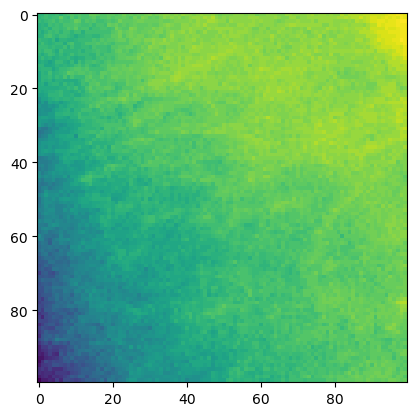

In [15]:
# example of an image

im = next(iter(train_loader))[0]
plt.imshow(im[0].permute(1,2,0).numpy()[...,0]);

In [16]:
# loss function to optimize
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Train the model
training_losses, training_accuracies, val_losses, val_accuracies = train(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=100, device='cuda')


  0%|          | 0/280 [00:00<?, ?it/s]

/home/masoud/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/70 [00:00<?, ?it/s]

1/100 - train loss: 0.5323 - train acc: 0.8605
1/100 - val loss: 0.5223 - val acc: 0.8646


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2/100 - train loss: 0.4647 - train acc: 0.8644
2/100 - val loss: 0.4588 - val acc: 0.8646


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

3/100 - train loss: 0.4473 - train acc: 0.8649
3/100 - val loss: 1.7472 - val acc: 0.2789


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

4/100 - train loss: 0.4532 - train acc: 0.8643
4/100 - val loss: 0.4699 - val acc: 0.8663


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

5/100 - train loss: 0.4193 - train acc: 0.8673
5/100 - val loss: 0.5600 - val acc: 0.8248


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

6/100 - train loss: 0.4069 - train acc: 0.8692
6/100 - val loss: 3.1681 - val acc: 0.3000


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

7/100 - train loss: 0.4095 - train acc: 0.8713
7/100 - val loss: 0.7173 - val acc: 0.7725


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

8/100 - train loss: 0.3743 - train acc: 0.8768
8/100 - val loss: 0.3752 - val acc: 0.8744


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

9/100 - train loss: 0.3669 - train acc: 0.8796
9/100 - val loss: 0.3735 - val acc: 0.8838


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

10/100 - train loss: 0.3788 - train acc: 0.8771
10/100 - val loss: 0.3727 - val acc: 0.8851


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

11/100 - train loss: 0.3813 - train acc: 0.8775
11/100 - val loss: 0.4403 - val acc: 0.8730


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

12/100 - train loss: 0.3444 - train acc: 0.8843
12/100 - val loss: 0.4263 - val acc: 0.8686


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

13/100 - train loss: 0.3504 - train acc: 0.8853
13/100 - val loss: 0.4176 - val acc: 0.8829


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

14/100 - train loss: 0.3275 - train acc: 0.8884
14/100 - val loss: 0.3998 - val acc: 0.8739


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

15/100 - train loss: 0.3176 - train acc: 0.8931
15/100 - val loss: 0.4420 - val acc: 0.8717


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

16/100 - train loss: 0.3142 - train acc: 0.8919
16/100 - val loss: 0.3132 - val acc: 0.9021


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

17/100 - train loss: 0.3060 - train acc: 0.8938
17/100 - val loss: 0.3728 - val acc: 0.8918


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

18/100 - train loss: 0.3477 - train acc: 0.8869
18/100 - val loss: 0.4056 - val acc: 0.8739


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

19/100 - train loss: 0.3215 - train acc: 0.8930
19/100 - val loss: 0.5110 - val acc: 0.8641


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

20/100 - train loss: 0.3063 - train acc: 0.8960
20/100 - val loss: 0.5934 - val acc: 0.8087


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

21/100 - train loss: 0.2725 - train acc: 0.9029
21/100 - val loss: 0.2748 - val acc: 0.9115


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

22/100 - train loss: 0.2600 - train acc: 0.9075
22/100 - val loss: 0.2734 - val acc: 0.9097


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

23/100 - train loss: 0.2545 - train acc: 0.9060
23/100 - val loss: 0.2903 - val acc: 0.9017


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

24/100 - train loss: 0.2489 - train acc: 0.9092
24/100 - val loss: 0.3221 - val acc: 0.8936


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

25/100 - train loss: 0.2453 - train acc: 0.9122
25/100 - val loss: 0.3131 - val acc: 0.8990


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

26/100 - train loss: 0.2445 - train acc: 0.9109
26/100 - val loss: 0.2880 - val acc: 0.9052


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

27/100 - train loss: 0.2431 - train acc: 0.9112
27/100 - val loss: 0.2890 - val acc: 0.9097


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

28/100 - train loss: 0.2387 - train acc: 0.9129
28/100 - val loss: 0.2724 - val acc: 0.9052


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

29/100 - train loss: 0.2363 - train acc: 0.9136
29/100 - val loss: 0.3122 - val acc: 0.8985


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

30/100 - train loss: 0.2309 - train acc: 0.9148
30/100 - val loss: 0.3030 - val acc: 0.9003


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

31/100 - train loss: 0.2319 - train acc: 0.9144
31/100 - val loss: 0.2668 - val acc: 0.9106


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

32/100 - train loss: 0.2332 - train acc: 0.9144
32/100 - val loss: 0.2620 - val acc: 0.9115


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

33/100 - train loss: 0.2209 - train acc: 0.9183
33/100 - val loss: 0.3576 - val acc: 0.8923


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

34/100 - train loss: 0.2252 - train acc: 0.9173
34/100 - val loss: 0.2657 - val acc: 0.9097


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

35/100 - train loss: 0.2222 - train acc: 0.9176
35/100 - val loss: 0.2862 - val acc: 0.9088


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

36/100 - train loss: 0.2195 - train acc: 0.9176
36/100 - val loss: 0.2838 - val acc: 0.9093


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

37/100 - train loss: 0.2116 - train acc: 0.9205
37/100 - val loss: 0.2601 - val acc: 0.9110


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

38/100 - train loss: 0.2152 - train acc: 0.9206
38/100 - val loss: 0.2589 - val acc: 0.9151


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

39/100 - train loss: 0.2119 - train acc: 0.9208
39/100 - val loss: 0.2698 - val acc: 0.9110


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

40/100 - train loss: 0.2040 - train acc: 0.9218
40/100 - val loss: 0.3202 - val acc: 0.9101


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

41/100 - train loss: 0.1966 - train acc: 0.9270
41/100 - val loss: 0.2578 - val acc: 0.9164


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

42/100 - train loss: 0.1917 - train acc: 0.9290
42/100 - val loss: 0.2529 - val acc: 0.9119


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

43/100 - train loss: 0.1882 - train acc: 0.9295
43/100 - val loss: 0.2529 - val acc: 0.9133


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

44/100 - train loss: 0.1877 - train acc: 0.9281
44/100 - val loss: 0.2538 - val acc: 0.9186


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

45/100 - train loss: 0.1881 - train acc: 0.9289
45/100 - val loss: 0.2535 - val acc: 0.9146


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

46/100 - train loss: 0.1884 - train acc: 0.9280
46/100 - val loss: 0.2553 - val acc: 0.9160


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

47/100 - train loss: 0.1884 - train acc: 0.9294
47/100 - val loss: 0.2513 - val acc: 0.9173


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

48/100 - train loss: 0.1855 - train acc: 0.9302
48/100 - val loss: 0.2519 - val acc: 0.9173


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

49/100 - train loss: 0.1864 - train acc: 0.9295
49/100 - val loss: 0.2623 - val acc: 0.9133


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

50/100 - train loss: 0.1841 - train acc: 0.9298
50/100 - val loss: 0.2676 - val acc: 0.9186


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

51/100 - train loss: 0.1796 - train acc: 0.9299
51/100 - val loss: 0.2495 - val acc: 0.9160


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

52/100 - train loss: 0.1778 - train acc: 0.9311
52/100 - val loss: 0.2541 - val acc: 0.9177


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

53/100 - train loss: 0.1832 - train acc: 0.9299
53/100 - val loss: 0.2543 - val acc: 0.9173


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

54/100 - train loss: 0.1808 - train acc: 0.9329
54/100 - val loss: 0.2576 - val acc: 0.9137


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

55/100 - train loss: 0.1766 - train acc: 0.9333
55/100 - val loss: 0.2594 - val acc: 0.9137


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

56/100 - train loss: 0.1780 - train acc: 0.9304
56/100 - val loss: 0.2598 - val acc: 0.9128


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

57/100 - train loss: 0.1754 - train acc: 0.9321
57/100 - val loss: 0.2609 - val acc: 0.9160


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

58/100 - train loss: 0.1768 - train acc: 0.9339
58/100 - val loss: 0.2565 - val acc: 0.9119


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

59/100 - train loss: 0.1727 - train acc: 0.9350
59/100 - val loss: 0.2664 - val acc: 0.9137


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

60/100 - train loss: 0.1731 - train acc: 0.9319
60/100 - val loss: 0.2653 - val acc: 0.9106


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

61/100 - train loss: 0.1732 - train acc: 0.9330
61/100 - val loss: 0.2621 - val acc: 0.9079


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

62/100 - train loss: 0.1708 - train acc: 0.9347
62/100 - val loss: 0.2568 - val acc: 0.9106


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

63/100 - train loss: 0.1705 - train acc: 0.9346
63/100 - val loss: 0.2596 - val acc: 0.9119


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

64/100 - train loss: 0.1725 - train acc: 0.9332
64/100 - val loss: 0.2576 - val acc: 0.9110


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

65/100 - train loss: 0.1674 - train acc: 0.9337
65/100 - val loss: 0.2627 - val acc: 0.9106


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

66/100 - train loss: 0.1682 - train acc: 0.9334
66/100 - val loss: 0.2592 - val acc: 0.9115


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

67/100 - train loss: 0.1670 - train acc: 0.9364
67/100 - val loss: 0.2625 - val acc: 0.9124


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

68/100 - train loss: 0.1671 - train acc: 0.9353
68/100 - val loss: 0.2623 - val acc: 0.9110


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

69/100 - train loss: 0.1650 - train acc: 0.9358
69/100 - val loss: 0.2590 - val acc: 0.9110


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

70/100 - train loss: 0.1691 - train acc: 0.9364
70/100 - val loss: 0.2647 - val acc: 0.9133


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

71/100 - train loss: 0.1728 - train acc: 0.9322
71/100 - val loss: 0.2635 - val acc: 0.9101


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

72/100 - train loss: 0.1679 - train acc: 0.9349
72/100 - val loss: 0.2619 - val acc: 0.9115


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

73/100 - train loss: 0.1744 - train acc: 0.9342
73/100 - val loss: 0.2659 - val acc: 0.9137


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

74/100 - train loss: 0.1687 - train acc: 0.9334
74/100 - val loss: 0.2676 - val acc: 0.9106


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

75/100 - train loss: 0.1653 - train acc: 0.9364
75/100 - val loss: 0.2641 - val acc: 0.9110


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

76/100 - train loss: 0.1709 - train acc: 0.9346
76/100 - val loss: 0.2625 - val acc: 0.9115


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

77/100 - train loss: 0.1671 - train acc: 0.9336
77/100 - val loss: 0.2620 - val acc: 0.9124


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

78/100 - train loss: 0.1735 - train acc: 0.9337
78/100 - val loss: 0.2641 - val acc: 0.9128


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

79/100 - train loss: 0.1666 - train acc: 0.9364
79/100 - val loss: 0.2619 - val acc: 0.9110


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

80/100 - train loss: 0.1677 - train acc: 0.9351
80/100 - val loss: 0.2654 - val acc: 0.9093


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

81/100 - train loss: 0.1712 - train acc: 0.9318
81/100 - val loss: 0.2601 - val acc: 0.9106


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

82/100 - train loss: 0.1708 - train acc: 0.9338
82/100 - val loss: 0.2623 - val acc: 0.9115


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

83/100 - train loss: 0.1689 - train acc: 0.9334
83/100 - val loss: 0.2639 - val acc: 0.9106


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

84/100 - train loss: 0.1669 - train acc: 0.9365
84/100 - val loss: 0.2643 - val acc: 0.9093


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

85/100 - train loss: 0.1683 - train acc: 0.9345
85/100 - val loss: 0.2637 - val acc: 0.9101


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

86/100 - train loss: 0.1666 - train acc: 0.9377
86/100 - val loss: 0.2617 - val acc: 0.9115


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

87/100 - train loss: 0.1693 - train acc: 0.9353
87/100 - val loss: 0.2622 - val acc: 0.9119


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

88/100 - train loss: 0.1693 - train acc: 0.9324
88/100 - val loss: 0.2627 - val acc: 0.9097


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

89/100 - train loss: 0.1679 - train acc: 0.9360
89/100 - val loss: 0.2661 - val acc: 0.9101


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

90/100 - train loss: 0.1716 - train acc: 0.9337
90/100 - val loss: 0.2626 - val acc: 0.9093


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

91/100 - train loss: 0.1660 - train acc: 0.9347
91/100 - val loss: 0.2608 - val acc: 0.9101


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

92/100 - train loss: 0.1696 - train acc: 0.9345
92/100 - val loss: 0.2653 - val acc: 0.9133


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

93/100 - train loss: 0.1671 - train acc: 0.9353
93/100 - val loss: 0.2626 - val acc: 0.9128


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

94/100 - train loss: 0.1682 - train acc: 0.9351
94/100 - val loss: 0.2655 - val acc: 0.9088


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

95/100 - train loss: 0.1657 - train acc: 0.9368
95/100 - val loss: 0.2607 - val acc: 0.9093


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

96/100 - train loss: 0.1710 - train acc: 0.9350
96/100 - val loss: 0.2629 - val acc: 0.9106


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

97/100 - train loss: 0.1711 - train acc: 0.9353
97/100 - val loss: 0.2634 - val acc: 0.9101


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

98/100 - train loss: 0.1668 - train acc: 0.9352
98/100 - val loss: 0.2639 - val acc: 0.9106


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

99/100 - train loss: 0.1636 - train acc: 0.9375
99/100 - val loss: 0.2643 - val acc: 0.9084


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

100/100 - train loss: 0.1638 - train acc: 0.9348
100/100 - val loss: 0.2614 - val acc: 0.9106


In [17]:
model.eval()
validation(model, test_loader, device="cuda")

  0%|          | 0/70 [00:00<?, ?it/s]

(0.261426940092185, 0.9105945462673223)

In [18]:
torch.save(model, "DDSM_5classes_adam_0.001.pt")

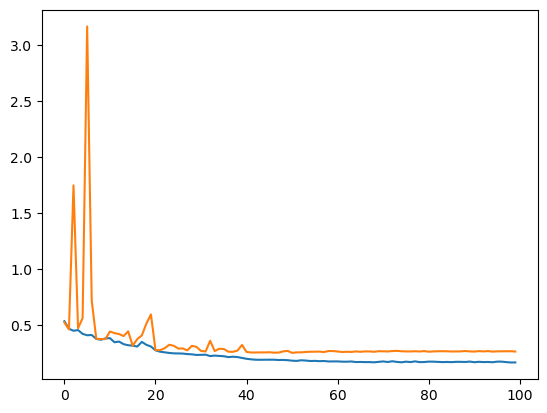

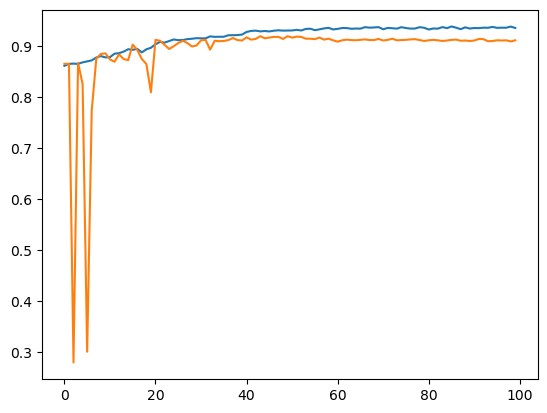

In [19]:
# plot the train / validation curve

plt.plot(training_losses)
plt.plot(val_losses)
plt.figure()
plt.plot(training_accuracies)
plt.plot(val_accuracies);